## Benchmark example 1

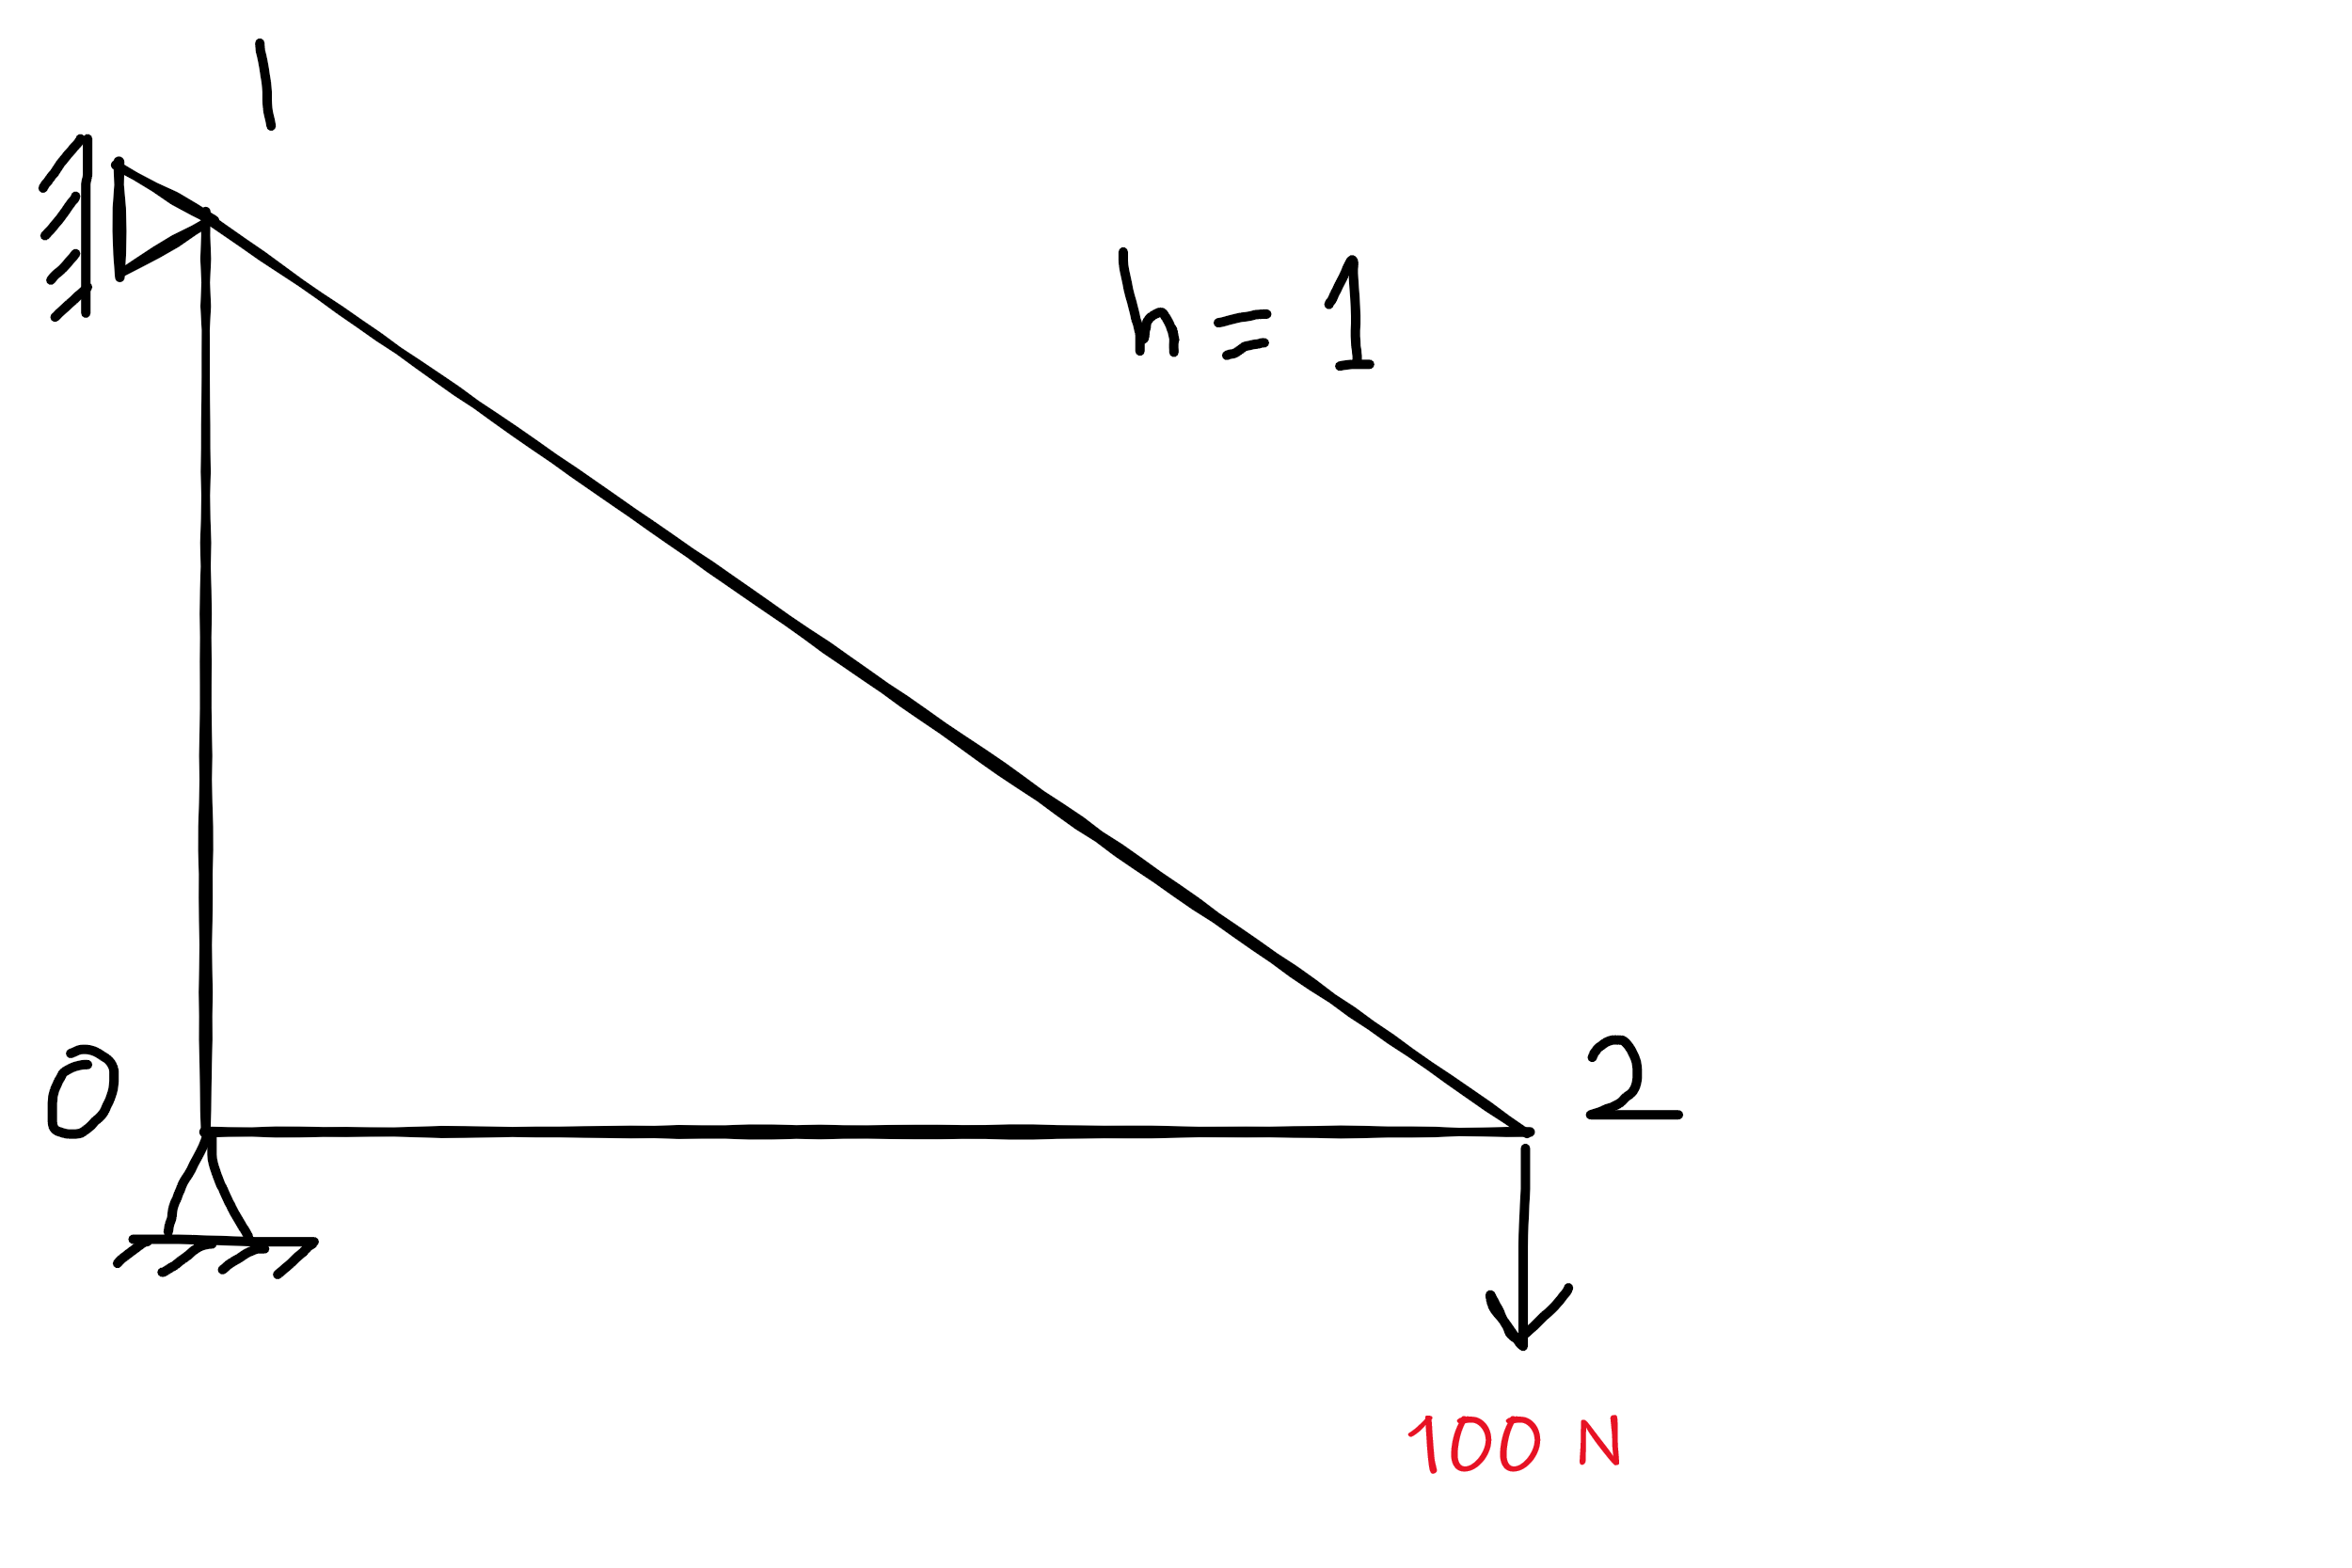

## Benchmark example 2

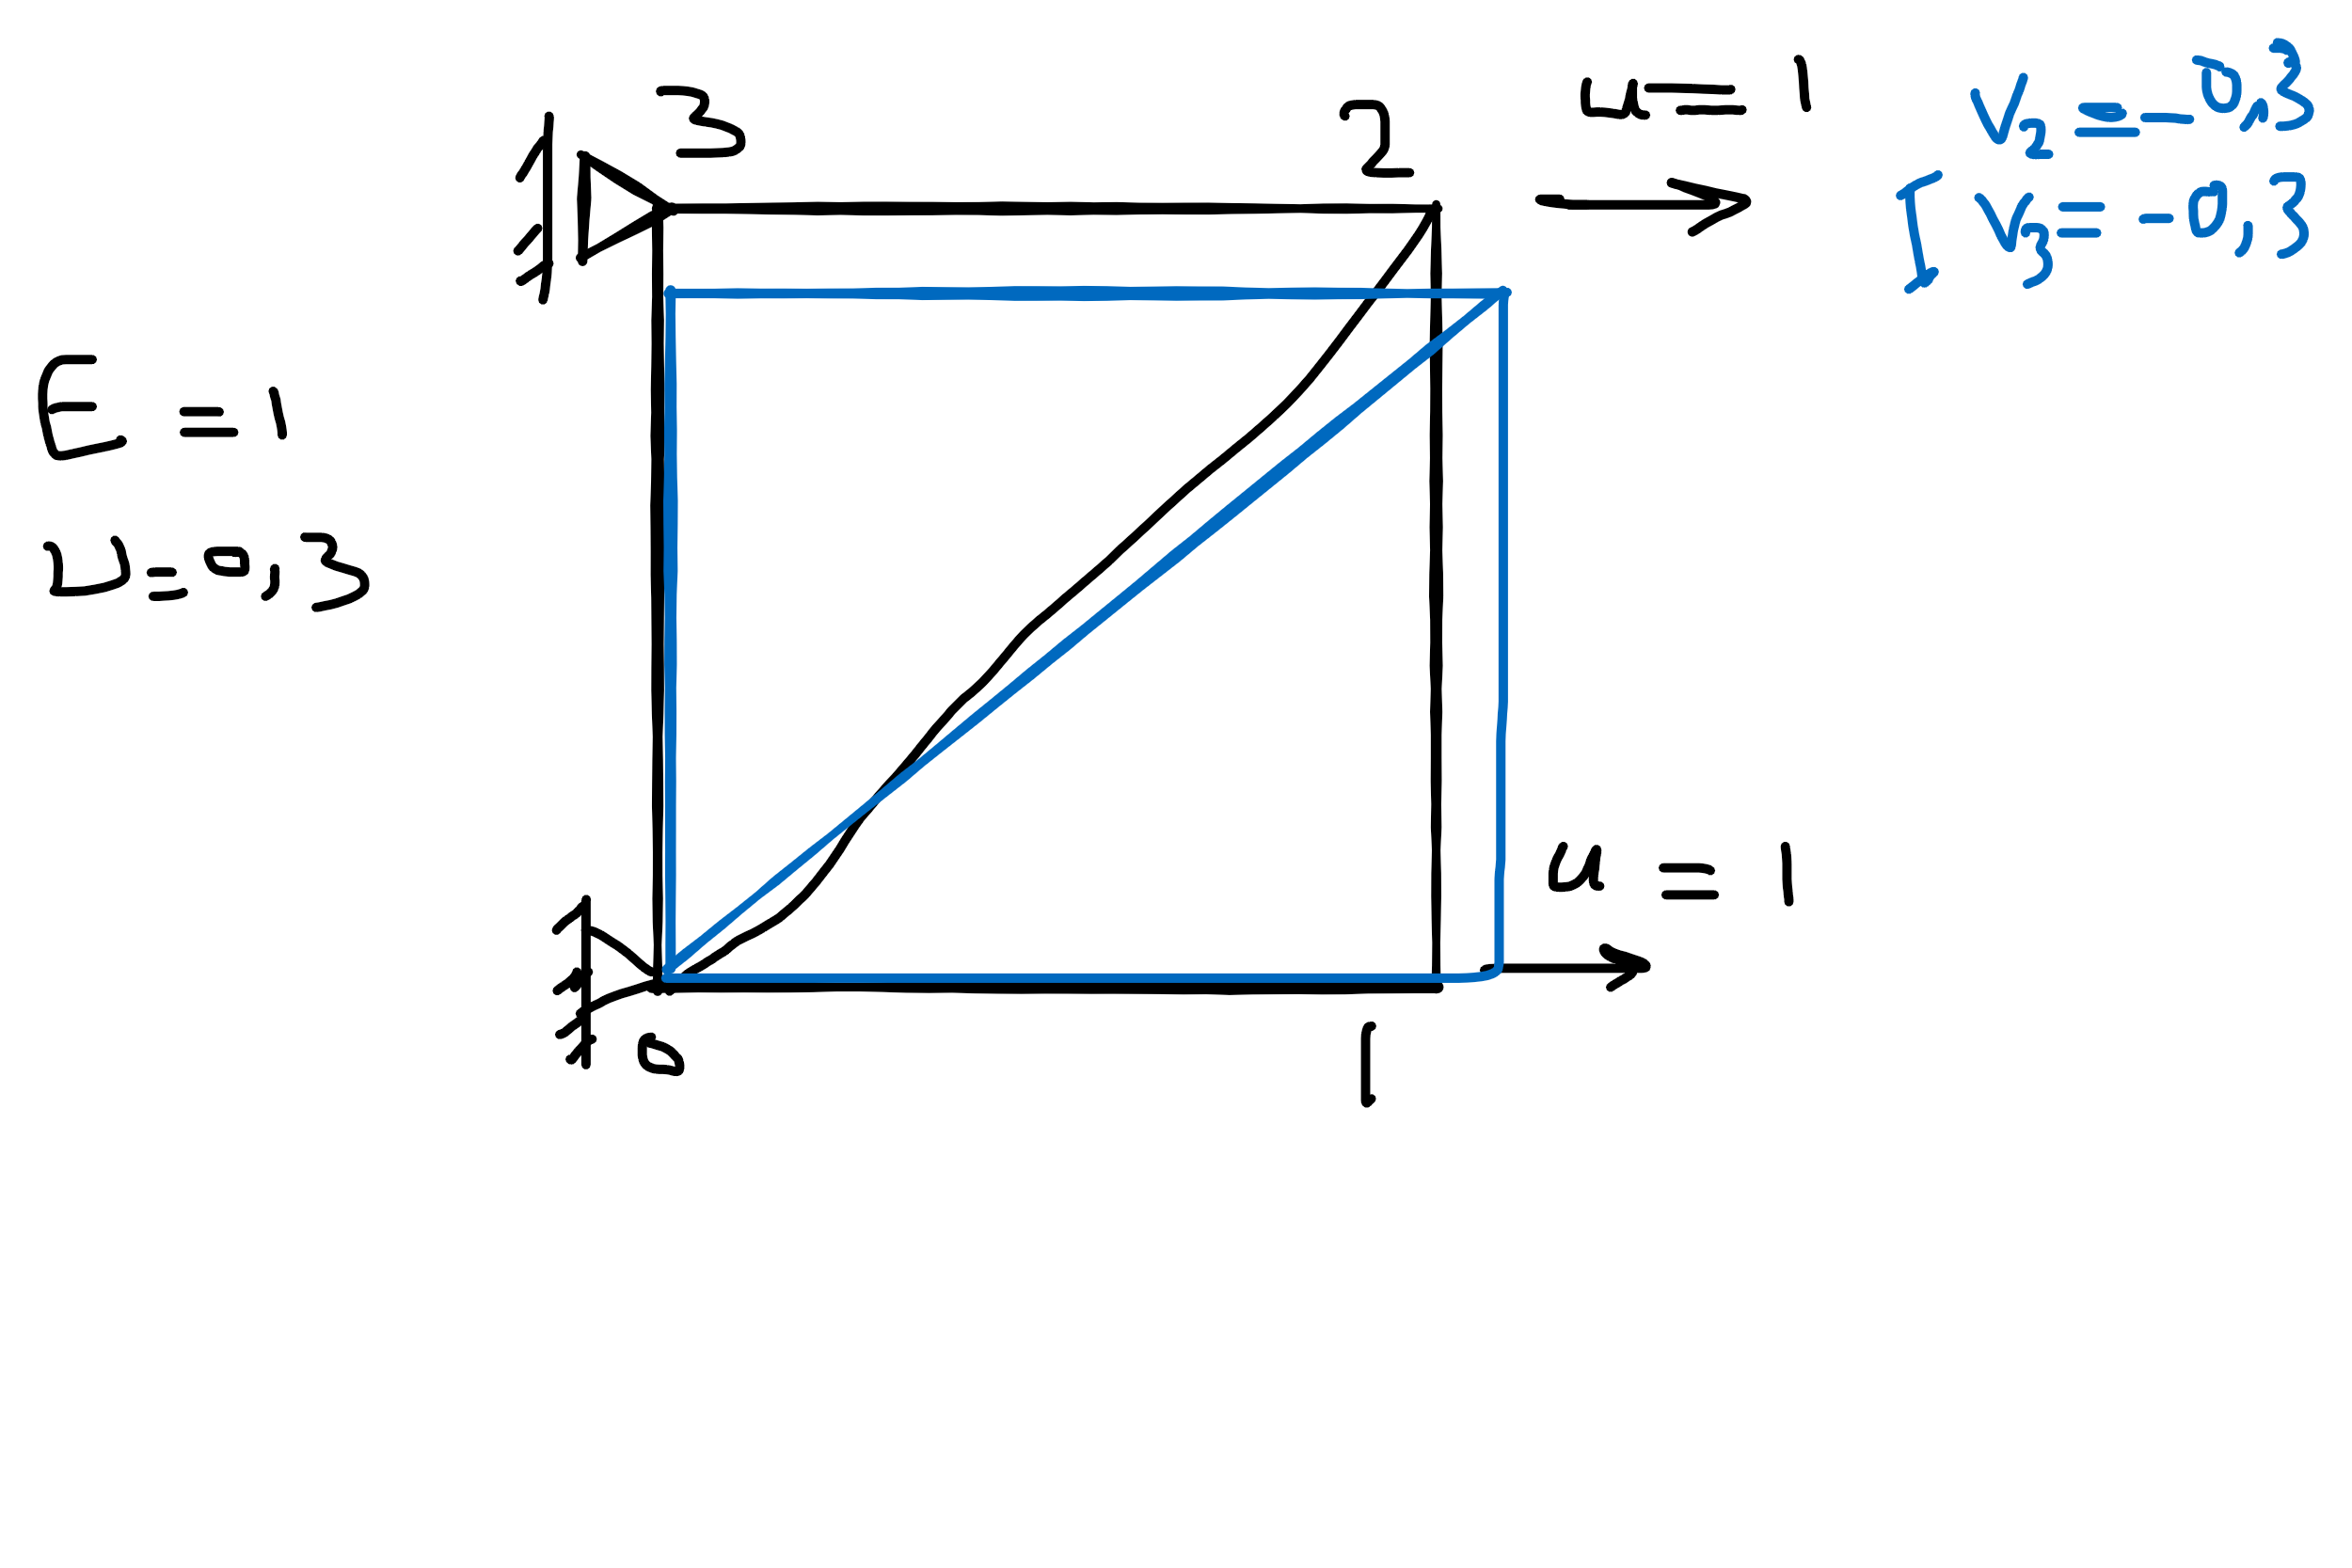

In [ ]:
%matplotlib widget
from bmcs_shell.api import FETriangularMesh, TriXDomainFE, XDomainFE, FETS2D3U1M, MATS2DElastic, TriXDomainMITC, FETS2DMITC, MATSShellElastic
import numpy as np
from ibvpy.bcond import BCDof
from ibvpy.sim.tstep_bc import TStepBC
# from ibvpy.mats.viz3d_scalar_field import \
#     Vis3DStateField, Viz3DScalarField

In [ ]:
# option=1: Benchmark example 1
# option=2: Benchmark example 1 with additional element in z direction 
# option=3: Benchmark example 2 (Patch test)
def run_sim(mitc = True, option=1):
    if option == 1:
        mesh = FETriangularMesh(
            X_Id=[[0,0,0], [0,100,0], [100,0,0]],
            I_Fi=[[0, 2, 1]]
            )
    elif option == 2:
        mesh = FETriangularMesh(
            X_Id=[[0,0,0], [0,100,0], [100,0,0], [0,100,100]],
            I_Fi=[[0,1,2], [0,2,3]]
            )
    elif option == 3:
        mesh = FETriangularMesh(
            X_Id=[[0,0,0], [100,0,0], [100,100,0], [0,100,0]],
            I_Fi=[[0,1,2], [2,3,0]]
            )
    if mitc:
        # shell element with 5 dofs (u_x, u_y, u_z, alpha, beta)

        if option == 1:
            fixed_dofs = [0, 1, 2, 3, 4,
                          5   , 7, 8, 9,
                                12, 13, 14]
            loaded_dofs = [11]
        elif option == 2:
            fixed_dofs = [0, 1, 2, 3, 4,
                          5   , 7, 8, 9,
                               12, 13, 14,
                                   18, 19]
            loaded_dofs = [11, 16]
        elif option == 3:
            fixed_dofs = [0, 1, 2, 3, 4,
                            7, 8, 9,
                            12, 13, 14,
                     15   , 17, 18, 19]
            loaded_dofs = [5, 10]

        mesh.fets = FETS2DMITC()
        xdomain = TriXDomainMITC(mesh=mesh)
        tmodel = MATSShellElastic(E=1 if option == 3 else 210000, nu=0.3)
    else:
        # plane element
        if option == 1:
            fixed_dofs = [0, 1, 2, 
                          3,   5, 
                               8]
            loaded_dofs = [7]
        elif option == 3:
            fixed_dofs = [0, 1, 2, 
                                5,
                                8,
                          9   , 11]
            loaded_dofs = [3, 6]
        xdomain = TriXDomainFE(mesh=mesh)
        tmodel = MATS2DElastic(E=1 if option == 3 else 210000, nu=0.3)

    u_cntl = 1 if option == 3 else -100
    bc_fixed = [BCDof(var= 'u', dof=dof, value=0) for dof in fixed_dofs]
    bc_loaded = [BCDof(var= 'u' if option == 3 else 'f', dof=dof, value=u_cntl) for dof in loaded_dofs]
    ts = TStepBC(
        domains=[(xdomain, tmodel)],
        bc=bc_fixed + bc_loaded,
    )
    s = ts.sim
    s.tloop.k_max = 10
    s.tline.step = 1
    s.tloop.verbose = True
    s.run()
    print('F_t')
    print(ts.hist.F_t)
    print('U_t')
    print(ts.hist.U_t)
    return xdomain

## Old plane element

In [ ]:
xdomain = run_sim(mitc = False, option=1)

In [ ]:
# Test strains
U_o = np.array([1, 0, 0,
                0, 0, 0,
                0, 0, 0,
#                0, 0, 0
               ], dtype=np.float_)
eps_Emab = xdomain.map_U_to_field(U_o)
eps_Emab

In [ ]:
xdomain.B_Eso

## Using shell element

In [ ]:
xdomain = run_sim(mitc = True, option=1)

In [ ]:
# Test strains
U_o = np.array([1, 0, 0, 0, 0,
                0, 0, 0, 0, 0,
                0, 0, 0, 0, 0,
#                 0, 0, 0, 0, 0,
               ], dtype=np.float_)
eps_Emp = xdomain.map_U_to_field(U_o)
eps_Emp

# Matrices derivation

## Calculating B matrix

The displacement approximation is constructed using in-plane shape functions and the transversal vector given by the rotations $\alpha$ and $\beta$ around the orthogonal in-plane vectors $v_{a1}$ and $v_{a2}$.  

$$
 u_a(\eta,\xi,\zeta) = N_i(\eta, \xi) \left( u_{ia} + \frac{1}{2} \zeta t_i
 \left(v_{ia1} \alpha_i - v_{ia2} \beta_i \right) \right)
$$

The goal is to transform the nodal values $u_{ia}$ and $\alpha_i$ and $\beta_i$ into a nodal vector with five values.

$$
\mathcal{V}_{iar} = [v_{ia1}, -v_{ia2} ] \\
\Phi_{ir} = [\alpha_i, \beta_i]
$$

$$
 u_a(\eta, \xi, \zeta) = 
 N_i(\eta, \xi) \, u_{ia} + N_i(\eta, \xi) \, 
 \frac{1}{2} \zeta t_i \mathcal{V}_{iar} \Phi_{ir}
$$

The nodal five parameter vector $\mathcal{U}_o$ with the $o$ denoting the three displacements $a$ and two rotations $r$ within a node is introduced using the two mappings

$$
 u_{a} = \delta_{ao} \mathcal{U}_o \\
 \Phi_{r} = \delta_{ro} \mathcal{U}_o
$$
where $\delta_{oi}$ and $\delta_{or}$ are the placement operators defined as
$$
 \delta_{ao} = 
 \left[
 \begin{array}{ccccc}
   1 & 0 & 0 & 0 & 0 \\
   0 & 1 & 0 & 0 & 0 \\
   0 & 0 & 1 & 0 & 0
 \end{array}
 \right]
$$
and 
$$
\delta_{ro} = 
\left[
\begin{array}{ccccc}
0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 1
\end{array}
\right]
$$

Then, the displacement approximation can be rewritten to

$$
 u_a(\eta, \xi, \zeta) = 
 N_i(\eta, \xi) \, \delta_{ao } \mathcal{U}_{io} + N_i(\eta, \xi) \, 
 \frac{1}{2} \zeta \mathcal{V}_{iar} \delta_{ro} \mathcal{U}_{io}
$$

so that, finally a decomposed mapping operator is found for all nodal parameters in the following form

$$
 u_a(\eta, \xi, \zeta)
 = 
 \left(
 N_i \delta_{ao} + N_i \frac{1}{2} t_i \zeta \mathcal{V}_{iar} \delta_{ro} \right)
 \mathcal{U}_{io}
$$

From this place, the derivation of strains and of the kinematic matrix $B$ follows the same lines as in the continuum.

**After renaming curvilinear coordinates and indices to match Bathe papers and the implementation in the code**

$$
 u_a(r, s, t)
 = 
 \left(
 N_i \delta_{ao} + (N t)_i \frac{1}{2} a_i \mathcal{V}_{iav} \delta_{vo} \right)
 \mathcal{U}_{io}
$$

\begin{align}
\mathrm{Green~Lagrange~strain~tensor:} \\
E_{ab} &= \frac{1}{2}
\left(\nabla \boldsymbol{u} + \nabla^T \boldsymbol{u} + \nabla^T \boldsymbol{u} \cdot \nabla \boldsymbol{u} \right) \\
\mathrm{Taking~only~the~linear~part:} \\
\varepsilon_{ab} &= \frac{1}{2}
\left(\frac{\partial u_a}{\partial x_b} +
 \frac{\partial u_b}{\partial x_a}\right) \\
&= \frac{1}{2}
\left( \delta_{ac} \delta_{bd} + \delta_{ad} \delta_{bc}\right)
 \frac{\partial u_c}{\partial x_d}
\\
&=
 \frac{1}{2}
\left( \delta_{ac} \delta_{bd} + \delta_{ad} \delta_{bc}\right)
 \left( \frac{\partial N_i}{\partial x_d} \delta_{co} + \frac{\partial (Nt)_i}{\partial x_d} \frac{1}{2} a_i \mathcal{V}_{icv} \delta_{vo} \right) \mathcal{U}_{io}
\\
 &=
 \frac{1}{2}
\left( \delta_{ac} \delta_{bd} + \delta_{ad} \delta_{bc}\right)
\left( \frac{\partial N_i}{\partial r_r}\frac{\partial r_r}{\partial x_d} \delta_{co} + \frac{\partial (Nt)_i}{\partial r_r}\frac{\partial r_r}{\partial x_d} \frac{1}{2} a_i \mathcal{V}_{icv} \delta_{vo} \right) \mathcal{U}_{io}
\\
 &=
 \frac{1}{2}
\left( \delta_{ac} \delta_{bd} + \delta_{ad} \delta_{bc}\right)
\left( \frac{\partial N_i}{\partial r_r} \delta_{co} + \frac{\partial (Nt)_i}{\partial r_r} \frac{1}{2} a_i \mathcal{V}_{icv} \delta_{vo} \right) (J^{-1})_{rd} \mathcal{U}_{io}
\\
 &=
 B_{iabo} \mathcal{U}_{io}
\end{align}

$\mathcal{U}_{io}$: the known nodal displacements for one element ($i$=num_of_nodes=3, $o$=dofs=5)

$\varepsilon_{ab}$: the evaluated strain at one Gauss point with coords $(r, s, t)$

$N(r, s, t)$

### Formulation with transformation to local coords system of the element $\theta$:
See P. 475 (The Finite Element Method, Zienkiewicz, 7th)

\begin{align}
\varepsilon_{ab} &= \frac{1}{2}
\left(\frac{\partial u_a}{\partial x_b} +
 \frac{\partial u_b}{\partial x_a}\right) \\
\bar{\varepsilon}_{ab} &= \frac{1}{2}
\left(\theta_{ae}\frac{\partial u_a}{\partial x_b}\theta_{bf} +
 \theta_{be}\frac{\partial u_b}{\partial x_a}\theta_{af}\right) \\
&= \frac{1}{2}
\left( \theta_{ae}\delta_{ac} \delta_{bd}\theta_{bf} + \theta_{be}\delta_{ad} \delta_{bc}\theta_{af}\right)
 \frac{\partial u_c}{\partial x_d}
\\
&=
 \frac{1}{2}
\left( \theta_{ae}\delta_{ac} \delta_{bd}\theta_{bf} + \theta_{be}\delta_{ad} \delta_{bc}\theta_{af}\right)
 \left( \frac{\partial N_i}{\partial x_d} \delta_{co} + \frac{\partial (Nt)_i}{\partial x_d} \frac{1}{2} a_i \mathcal{V}_{icv} \delta_{vo} \right) \mathcal{U}_{io}
\\
 &=
 \frac{1}{2}
\left( \theta_{ae}\delta_{ac} \delta_{bd}\theta_{bf} + \theta_{be}\delta_{ad} \delta_{bc}\theta_{af}\right)
\left( \frac{\partial N_i}{\partial r_r}\frac{\partial r_r}{\partial x_d} \delta_{co} + \frac{\partial (Nt)_i}{\partial r_r}\frac{\partial r_r}{\partial x_d} \frac{1}{2} a_i \mathcal{V}_{icv} \delta_{vo} \right) \mathcal{U}_{io}
\\
 &=
 \frac{1}{2}
\left( \theta_{ae}\delta_{ac} \delta_{bd}\theta_{bf} + \theta_{be}\delta_{ad} \delta_{bc}\theta_{af}\right)
\left( \frac{\partial N_i}{\partial r_r} \delta_{co} + \frac{\partial (Nt)_i}{\partial r_r} \frac{1}{2} a_i \mathcal{V}_{icv} \delta_{vo} \right) (J^{-1})_{rd} \mathcal{U}_{io}
\\
 &=
 B_{iabo} \mathcal{U}_{io}
\end{align}

Where $\bar{\varepsilon}_{ab}$ is strains according to coordinates system of the element (defined by v1, v2, v3 base vectors which compose $\theta$ = [v1, v2, v3]) 

### Formulation according to Bathe papers strain formula

\begin{align}
\varepsilon_{ij} &= \frac{1}{2} \left(\vec{g}_i \cdot \vec{u}_{,j} + \vec{g}_j \cdot \vec{u}_{,i} \right) \\
\varepsilon_{ij} &= \frac{1}{2} \left(\frac{\partial{\vec{x}}}{\partial{r_i}} \cdot \frac{\partial{\vec{u}}}{\partial{r_j}} + \frac{\partial{\vec{x}}}{\partial{r_j}} \cdot \frac{\partial{\vec{u}}}{\partial{r_i}} \right)
\\
\varepsilon_{ij} &= \frac{1}{2} \left(\frac{\partial{x_k}}{\partial{r_i}} \frac{\partial{u_k}}{\partial{r_j}} + \frac{\partial{x_k}}{\partial{r_j}} \frac{\partial{u_k}}{\partial{r_i}} \right)
\\
\mathrm{Change~indices:}
\\
\varepsilon_{ab} &= \frac{1}{2} \left(\frac{\partial{x_f}}{\partial{r_a}} \frac{\partial{u_f}}{\partial{r_b}} + \frac{\partial{x_f}}{\partial{r_b}} \frac{\partial{u_f}}{\partial{r_a}} \right)
\\
&= \frac{1}{2}
\left( \delta_{ac} \delta_{bd} + \delta_{ad} \delta_{bc}\right)
 \frac{\partial{x_f}}{\partial{r_c}} \frac{\partial{u_f}}{\partial{r_d}}
\\
&=
 \frac{1}{2}
\left( \delta_{ac} \delta_{bd} + \delta_{ad} \delta_{bc}\right) J_{fc}
 \left( \frac{\partial N_i}{\partial r_d} \delta_{fo} + \frac{\partial (Nt)_i}{\partial r_d} \frac{1}{2} a_i \mathcal{V}_{ifv} \delta_{vo} \right) \mathcal{U}_{io}
\\
 &=
 B_{iabo} \mathcal{U}_{io}
\end{align}

We see that the only difference in comparison to the standard formulation above is Jacobian $J$ instead of Jacobian inverse $J^{-1}$ and some indices! but why not inverse J?!

### To debug the shell element, investigate only why this b matrix doesn't look like B_Eso for plane element (in backend you should use tri_xdomain_fe without transformation to compare B matrices)

Example for comparing B matrix:

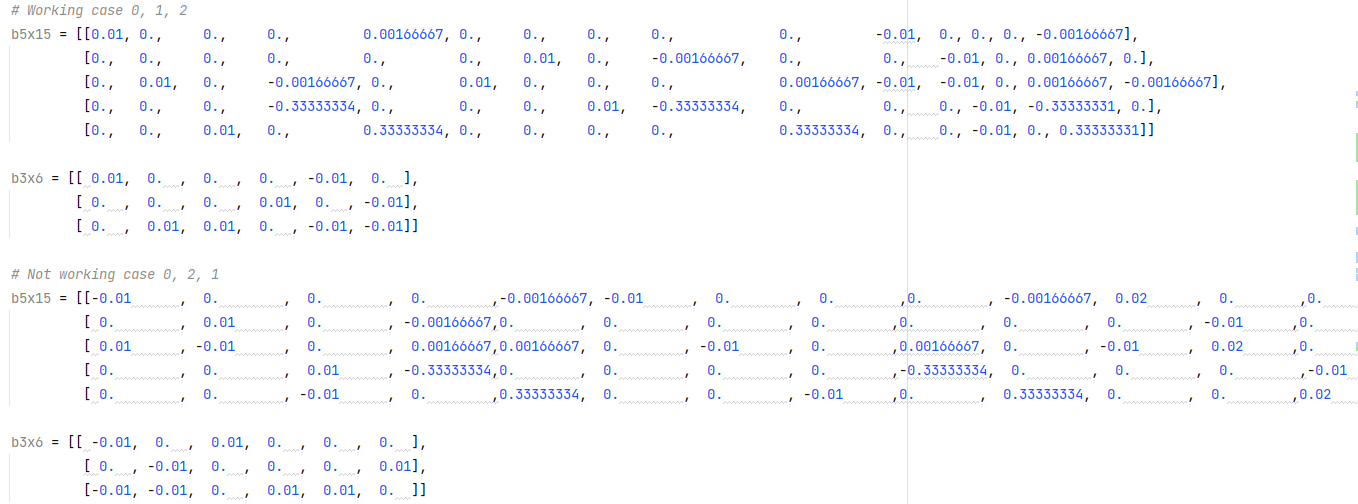

In [ ]:
xdomain.B_Empf

In [ ]:
# Real order of the indices 
xdomain.F_N

### Finding transformation matrix $\theta$
See P. 475 (Zienkiewicz FEM book)

In [ ]:
def get_theta():
    J_Fmrd = xdomain.dx_dr_Fmrd
    dx_dr_Fmd = J_Fmrd[..., 0, :]
    dx_ds_Fmd = J_Fmrd[..., 1, :]
    V3_Fmd = np.cross(dx_dr_Fmd, dx_ds_Fmd)

    e_2_Fmd = np.zeros_like(V3_Fmd)
    e_2_Fmd[..., 0] = 1
    V1_Fmd = np.cross(e_2_Fmd, V3_Fmd)

    # min_Fm1 = np.abs(V3_Fmd).argmin(axis=2)
    # min_Fm1 = min_Fm1[..., np.newaxis]
    # tmp_Fmd = np.zeros_like(V3_Fmd, dtype=np.int_)
    # tmp_Fmd[..., :] = np.arange(3)
    # min_mask_Fmd = tmp_Fmd == min_Fm1
    # e_x_min_Fmd = min_mask_Fmd * 1
    # V1_Fmd = np.cross(e_x_min_Fmd, V3_Fmd)

    V2_Fmd = np.cross(V3_Fmd, V1_Fmd)

    v1_Fmd = xdomain._normalize(V1_Fmd)
    v2_Fmd = xdomain._normalize(V2_Fmd)
    v3_Fmd = xdomain._normalize(V3_Fmd)

    v_Fmdj = np.zeros((*v1_Fmd.shape, 3), dtype='f')
    v_Fmjd = np.einsum('Fmdj->Fmjd', v_Fmdj)
    v_Fmjd[..., 0, :] = v1_Fmd
    v_Fmjd[..., 1, :] = v2_Fmd
    v_Fmjd[..., 2, :] = v3_Fmd
    return v_Fmjd # theta

theta_Fmjd = get_theta()
theta_Fmjd

In [ ]:
# TODO: THE PROBLEM Could be IN THE USAGE OF dh_imr and dht_imr in einsum, their i is not compatiable with the i of other values

delta35_co = np.zeros((3, 5), dtype='f')
delta35_co[(0, 1, 2), (0, 1, 2)] = 1
delta25_vo = np.zeros((2, 5), dtype='f')
delta25_vo[(0, 1), (3, 4)] = 1

_, v1_Fid, v2_Fid = xdomain.v_vectors
V_Ficv = np.zeros((*v2_Fid.shape, 2), dtype='f')
V_Ficv[..., 0] = v1_Fid
V_Ficv[..., 1] = -v2_Fid

# Thickness a
a = xdomain.fets.a
dh_imr = xdomain.fets.dh_imr
dht_imr = xdomain.fets.dht_imr
# dh_imr = np.flip(dh_imr, 0)
# dht_imr = np.flip(dht_imr, 0)

dh_Fimr = xdomain.dh_Fimr
dht_Fimr = xdomain.dht_Fimr
# dh_Fimr = np.flip(dh_Fimr, 1)
# dht_Fimr = np.flip(dht_Fimr, 1)

delta = np.identity(3)
Diff1_abcd = 0.5 * (
        np.einsum('ac,bd->abcd', delta, delta) +
        np.einsum('ad,bc->abcd', delta, delta)
)

# Jacobian
Vn_Fid, _, _ = xdomain.v_vectors
# X_Fid = xdomain.X_Id[xdomain.mesh.I_Fi]
X_Fid = xdomain.X_Id[xdomain.F_N]

a = xdomain.fets.a
dx_dr1_Fmrid = np.einsum('Fid, imr -> Fmrid', X_Fid, dh_imr)
dx_dr2_Fmrid = np.einsum('Fid, imr -> Fmrid', 0.5 * a * Vn_Fid, dht_imr)
# dx_dr1_Fmrid = np.einsum('Fid, Fimr -> Fmrid', X_Fid, dh_Fimr)
# dx_dr2_Fmrid = np.einsum('Fid, Fimr -> Fmrid', 0.5 * a * Vn_Fid, dht_Fimr)
dx_dr1_Fmrd = np.sum(dx_dr1_Fmrid, axis=3)
dx_dr2_Fmrd = np.sum(dx_dr2_Fmrid, axis=3)
dx_dr_Fmrd = dx_dr1_Fmrd + dx_dr2_Fmrd

J_Fmrd = dx_dr_Fmrd

inv_J_Fmrd = np.linalg.inv(J_Fmrd)
det_J_Fm = np.linalg.det(J_Fmrd)
B1_Emiabo = np.einsum('abcd, imr, co, Emrd -> Emiabo', Diff1_abcd, dh_imr, delta35_co, inv_J_Fmrd)
B2_Emiabo = np.einsum('abcd, imr, Eicv, vo, Emrd -> Emiabo', Diff1_abcd, dht_imr, 0.5 * a * V_Ficv, delta25_vo,
                      inv_J_Fmrd)
# According to eps formula in Bathe papers!?
# B1_Emiabo = np.einsum('abcd, imd, fo, Emfc -> Emiabo', Diff1_abcd, dh_imr, delta35_co, J_Fmrd)
# B2_Emiabo = np.einsum('abcd, imd, Eifv, vo, Emfc -> Emiabo', Diff1_abcd, dht_imr, 0.5 * a * V_Ficv, delta25_vo,
#                       J_Fmrd)
# Considering dh_Fimr and dht_Fimr which takes each facet indices order in account:
# B1_Emiabo = np.einsum('abcd, Eimr, co, Emrd -> Emiabo', Diff1_abcd, dh_Fimr, delta35_co, inv_J_Fmrd)
# B2_Emiabo = np.einsum('abcd, Eimr, Eicv, vo, Emrd -> Emiabo', Diff1_abcd, dht_Fimr, 0.5 * a * V_Ficv, delta25_vo,
#                       inv_J_Fmrd)
B_Emiabo = B1_Emiabo + B2_Emiabo
# B_Emiabo = B1_Emiabo

# B_Emiabo = np.flip(B_Emiabo, 2)

# Mapping ab to p (3x3 -> 5)
B_Emipo = B_Emiabo[:, :, :, (0, 1, 0, 1, 2), (0, 1, 1, 2, 0), :]
# What follows is to adjust shear strains: [e_xx, e_yy, e_xy + e_yx, e_yz + e_zy, e_zx + e_xz]
B_Emipo[:, :, :, 2:, :] = B_Emipo[:, :, :, 2:, :] + B_Emiabo[:, :, :, (1, 2, 0), (0, 1, 2), :]
# B_Emipo[:, :, :, 2:, :] = 2 * B_Emipo[:, :, :, 2:, :]

E, m, i, p, o = B_Emipo.shape
B_Empio = np.einsum('Emipo->Empio', B_Emipo)
B_Empf = B_Empio.reshape((E, m, p, i * o))
# p: index with max value 5
# f: index with max value 15
B_Empf

# U_o = np.array([0, 1, 1, 1, 0,
#                 0, 0, 0, 0, 0,
#                 1, 1, 0, 0, 0,
# #                 0, 0, 0, 0, 0,
#                ], dtype=np.float_)
# U_Eio = U_o[xdomain.o_Eia]
# # U_Eio = U_o.reshape((-1, xdomain.fets.n_nodal_dofs))[xdomain.F_N]
# # U_Eio = U_o.reshape((-1, xdomain.fets.n_nodal_dofs))[xdomain.mesh.I_Fi]

# eps_Emab = np.einsum('Emiabo, Eio -> Emab', B_Emiabo, U_Eio)
# eps_Emp = eps_Emab[:, :, (0, 1, 0, 1, 2), (0, 1, 1, 2, 0)]

# # What follows is to adjust shear strains: [e_xx, e_yy, e_xy + e_yx, e_yz + e_zy, e_zx + e_xz]
# eps_Emp[:, :, 2:] = eps_Emp[:, :, 2:] + eps_Emab[:, :, (1, 2, 0), (0, 1, 2)]
# # eps_Emp[:, :, 2:] = 2 * eps_Emp[:, :, 2:]

# eps_Emp

### B with transformation

## With transformation:

In [ ]:
theta_Fmjd = get_theta()
theta_Fmjd

In [ ]:
# TODO: THE PROBLEM IS IN THE USAGE OF dh_imr and dht_imr in einsum, their i is not compatiable with the i of other values

delta35_co = np.zeros((3, 5), dtype='f')
delta35_co[(0, 1, 2), (0, 1, 2)] = 1
delta25_vo = np.zeros((2, 5), dtype='f')
delta25_vo[(0, 1), (3, 4)] = 1

_, v1_Fid, v2_Fid = xdomain.v_vectors
V_Ficv = np.zeros((*v2_Fid.shape, 2), dtype='f')
V_Ficv[..., 0] = v1_Fid
V_Ficv[..., 1] = -v2_Fid

# Thickness a
a = xdomain.fets.a
dh_imr = xdomain.fets.dh_imr
dht_imr = xdomain.fets.dht_imr
# dh_imr = np.flip(dh_imr, 0)
# dht_imr = np.flip(dht_imr, 0)

dh_Fimr = xdomain.dh_Fimr
dht_Fimr = xdomain.dht_Fimr
# dh_Fimr = np.flip(dh_Fimr, 1)
# dht_Fimr = np.flip(dht_Fimr, 1)

delta = np.identity(3)
# Diff1_abcd = 0.5 * (
#         np.einsum('ac,bd->abcd', delta, delta) +
#         np.einsum('ad,bc->abcd', delta, delta)
# )
Diff1_Fmabcd = 0.5 * (
        np.einsum('Fmae, ac, bd, Fmbf ->Fmabcd', theta_Fmjd, delta, delta, theta_Fmjd) +
        np.einsum('Fmbe, ad, bc, Fmaf ->Fmabcd', theta_Fmjd, delta, delta, theta_Fmjd)
)

# Jacobian
Vn_Fid, _, _ = xdomain.v_vectors
# X_Fid = xdomain.X_Id[xdomain.mesh.I_Fi]
X_Fid = xdomain.X_Id[xdomain.F_N]

a = xdomain.fets.a
dx_dr1_Fmrid = np.einsum('Fid, imr -> Fmrid', X_Fid, dh_imr)
dx_dr2_Fmrid = np.einsum('Fid, imr -> Fmrid', 0.5 * a * Vn_Fid, dht_imr)
# dx_dr1_Fmrid = np.einsum('Fid, Fimr -> Fmrid', X_Fid, dh_Fimr)
# dx_dr2_Fmrid = np.einsum('Fid, Fimr -> Fmrid', 0.5 * a * Vn_Fid, dht_Fimr)
dx_dr1_Fmrd = np.sum(dx_dr1_Fmrid, axis=3)
dx_dr2_Fmrd = np.sum(dx_dr2_Fmrid, axis=3)
dx_dr_Fmrd = dx_dr1_Fmrd + dx_dr2_Fmrd

J_Fmrd = dx_dr_Fmrd

inv_J_Fmrd = np.linalg.inv(J_Fmrd)
det_J_Fm = np.linalg.det(J_Fmrd)
B1_Emiabo = np.einsum('Emabcd, imr, co, Emrd -> Emiabo', Diff1_Fmabcd, dh_imr, delta35_co, inv_J_Fmrd)
B2_Emiabo = np.einsum('Emabcd, imr, Eicv, vo, Emrd -> Emiabo', Diff1_Fmabcd, dht_imr, 0.5 * a * V_Ficv, delta25_vo,
                      inv_J_Fmrd)
# why Ficv instead of Eicv
# B1_Emiabo = np.einsum('Emabcd, Eimr, co, Emrd -> Emiabo', Diff1_Fmabcd, dh_Fimr, delta35_co, inv_J_Fmrd)
# B2_Emiabo = np.einsum('Emabcd, Eimr, Eicv, vo, Emrd -> Emiabo', Diff1_Fmabcd, dht_Fimr, 0.5 * a * V_Ficv, delta25_vo,
#                       inv_J_Fmrd)
# B_Emiabo = B1_Emiabo + B2_Emiabo
B_Emiabo = B1_Emiabo + B2_Emiabo

# B_Emiabo = np.flip(B_Emiabo, 2)

# Mapping ab to p (3x3 -> 5)
B_Emipo = B_Emiabo[:, :, :, (0, 1, 0, 1, 2), (0, 1, 1, 2, 0), :]
# What follows is to adjust shear strains: [e_xx, e_yy, e_xy + e_yx, e_yz + e_zy, e_zx + e_xz]
B_Emipo[:, :, :, 2:, :] = B_Emipo[:, :, :, 2:, :] + B_Emiabo[:, :, :, (1, 2, 0), (0, 1, 2), :]
# B_Emipo[:, :, :, 2:, :] = 2 * B_Emipo[:, :, :, 2:, :]

E, m, i, p, o = B_Emipo.shape
B_Empio = np.einsum('Emipo->Empio', B_Emipo)
B_Empf = B_Empio.reshape((E, m, p, i * o))
# p: index with max value 5
# f: index with max value 15

# U_o = np.array([0, 1, 1, 1, 0,
#                 0, 0, 0, 0, 0,
#                 1, 1, 0, 0, 0,
# #                 0, 0, 0, 0, 0,
#                ], dtype=np.float_)
# U_Eio = U_o[xdomain.o_Eia]
# # U_Eio = U_o.reshape((-1, xdomain.fets.n_nodal_dofs))[xdomain.F_N]
# # U_Eio = U_o.reshape((-1, xdomain.fets.n_nodal_dofs))[xdomain.mesh.I_Fi]

# eps_Emab = np.einsum('Emiabo, Eio -> Emab', B_Emiabo, U_Eio)
# eps_Emp = eps_Emab[:, :, (0, 1, 0, 1, 2), (0, 1, 1, 2, 0)]

# # What follows is to adjust shear strains: [e_xx, e_yy, e_xy + e_yx, e_yz + e_zy, e_zx + e_xz]
# eps_Emp[:, :, 2:] = eps_Emp[:, :, 2:] + eps_Emab[:, :, (1, 2, 0), (0, 1, 2)]
# # eps_Emp[:, :, 2:] = 2 * eps_Emp[:, :, 2:]

# eps_Emp

B_Empf

## Calculating stiffness matrix k

In [ ]:
xdomain.o_Eia

In [ ]:
xdomain.o_Eia.reshape(-1, 3 * 5)

In [ ]:
w_m = self.fets.w_m  # Gauss points weights
B_Emiabo, det_J_Fm = self.B_Emiabo

B_Empf = self._get_B_Empf()
k2_Emop = self.integ_factor * np.einsum('m, Empf, Ept, Emtq, Em -> Emfq', w_m, B_Empf, D_Est, B_Empf,
                                           det_J_Fm)
k2_Eop = np.sum(k2_Emop, axis=1)

o_Ei = self.o_Eia.reshape(-1, 3 * 5)
return SysMtxArray(mtx_arr=k2_Eop, dof_map_arr=o_Ei)

In [ ]:
w_m = xdomain.fets.w_m # Gauss points weights
B_Emiabo, det_J_Fm = xdomain.B_Emiabo
E_ = 1000
nu_ = 0.3
k = 5/6
D_Est = E_ / (1 - nu_ ** 2) * np.array([[[1, nu_, 0, 0, 0],
                                        [nu_, 1, 0, 0, 0],
                                        [0, 0, 0.5 * (1 - nu_),     0, 0],
                                        [0, 0, 0, 0.5 * (1 - nu_) * k, 0],
                                        [0, 0, 0, 0, 0.5 * (1 - nu_) * k]]])

# Mapping ab to p (3x3 -> 5)
B_Emipo = B_Emiabo[:, :, :, (0, 1, 0, 1, 0), (0, 1, 1, 2, 2), :]

E, m, i, p, o = B_Emipo.shape
B_Empio = np.einsum('Emipo->Empio', B_Emipo)
B_Empf = B_Empio.reshape((E, m, p, 3 * o))

k2_Emop = xdomain.integ_factor * np.einsum('m, Empf, Ept, Emtq, Em -> Emfq', w_m, B_Empf, D_Est, B_Empf,
                                           det_J_Fm)

k2_Eop = np.sum(k2_Emop, axis=1)
k2_Eop

o_Ei = xdomain.o_Eia.reshape(-1, 3 * 5)
o_Ei
# SysMtxArray(mtx_arr=k2_Eop, dof_map_arr=o_Ei)

## Force

In [ ]:
sig_Ems = np.array([[[0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0]]])

In [ ]:
B_Emiabo, det_J_Fm = xdomain.B_Emiabo

B_Empf = xdomain._get_B_Empf()
f_Emf = xdomain.integ_factor * np.einsum('m, Emsf, Ems, Em -> Emf', xdomain.fets.w_m, B_Empf, sig_Ems, det_J_Fm)
f_Ef = np.sum(f_Emf, axis=1)

o_Ei = xdomain.o_Eia.reshape(-1, 3 * 5)

o_Ei.flatten(), f_Ef.flatten()

## 2. Solving plane element manually

In [ ]:
h = 1

x1 = 0
y1 = 0
x2 = 0
y2 = 100
x3 = 100
y3 = 0

E = 210000
nu = 0.3
A = 100*100/2
C = E / (1 - nu ** 2) * np.array([[1, nu, 0], [nu, 1, 0], [0, 0, 0.5 * (1 - nu)]])
B = (1/(2*A)) * np.array([
    [y2-y3, 0, y3-y1, 0, y1-y2, 0],
    [0, x3-x2, 0, x1-x3, 0, x2-x1],
    [x3-x2, y2-y3, x1-x3, y3-y1, x2-x1, y1-y2]
])
B

In [ ]:
k = A*h*np.dot(B.T, C)
k = np.dot(k, B)
k

In [ ]:
k_dof = k[3:,3:]
k_dof

In [ ]:
k_inv = np.linalg.inv(k_dof)
k_inv

In [ ]:
f = np.array([0, 0, -100])
u = np.dot(k_inv, f)
u

## 3. Solving plane element using ibvpy

In [ ]:
xdomain.T_Fab

In [ ]:
xdomain.x_Eia

In [ ]:
xdomain.J_Emar

In [ ]:
F_to = ts.hist.F_t
U_to = ts.hist.U_t
F_loaded = np.sum(F_to[:, loaded_dofs], axis=-1)
F_fixed = np.sum(F_to[:, fixed_dofs], axis=-1)
U_loaded = np.average(U_to[:, loaded_dofs], axis=-1)
F_loaded
U_to[-1]

In [ ]:
U1 = ts.hist.U_t[-1]
print(U1)
eps1 = ts.fe_domain[0].xdomain.map_U_to_field(U1)
sig1, _ = ts.fe_domain[0].tmodel.get_corr_pred(eps1,1)
sig_x, sig_y, tau = sig1.T
sig_ab = np.einsum('ab...->...ab', np.array([[sig_x, tau], [tau, sig_y]], dtype=np.float))
sig_val, sig_dir = np.linalg.eig(sig_ab)
[np.min(sig_val), np.max(sig_val)]

In [ ]:
Diff1_abcd

$$
J_{ar} =  \frac{\partial N_i}{\partial \eta_r} 
x_{ia}
$$
this can be transformed 
$$
J_{Emar} = \left. \frac{\partial N_i}{\partial \eta_r} \right|_m
x_{Eia}
$$
Zienkiewicz

In [ ]:
x_Ia = xdomain.X_Id[..., :-1]
x_Eia = x_Ia[xdomain.I_Ei]
delta = np.identity(2) 
Diff1_abcd = 0.5 * (
        np.einsum('ac,bd->abcd', delta, delta) +
        np.einsum('ad,bc->abcd', delta, delta)
)
dN_mir = np.array([[[1, 0], [0, 1], [-1, -1]]], dtype=np.float_)
J_Emar = np.einsum('mir, Eia -> Emar', dN_mir, x_Eia)
inv_J_Emra = np.linalg.inv(J_Emar)
det_J_Emra = np.linalg.det(J_Emar)
B_Eimabc = np.einsum('abcd, mir, Emrd -> Eimabc', Diff1_abcd, dN_mir, inv_J_Emra)
U_Eic = np.array([[[0, 0], [1, 0], [0, 1]]], dtype=np.float_)
eps_Emab = np.einsum('Eimabc,Eic->Emab', B_Eimabc, U_Eic)
eps_Emab

In [ ]:
eps2_Emab = np.einsum('Eimabc,Eic->Emab', xdomain.B1_Eimabc, U_Eic)
eps2_Emab